# LLB Implementation mit zeitlicher Interpolation aller temperaturabhaengiger Parameter

In [1]:
import numpy as np
from scipy import constants as sp
from scipy import optimize as op
from scipy import interpolate as ip
from matplotlib import pyplot as plt
import itertools
import time
from scipy.integrate import solve_ivp

In [2]:
class material():
    def __init__(self, name, S, Tc, lamda, muat, kappa_anis, anis_axis, K_0, A_0, Ms, Delta):
        self.name=name                                      # name of the material used for the string representation of the class
        self.S=S                                            # effective spin
        self.Tc=Tc                                          # Curie temperature
        self.J=3*self.S/(self.S+1)*sp.k*self.Tc             # mean field exchange coupling constant
        self.mean_mag_map=self.create_mean_mag_map()         # creates the mean magnetization map over temperature as an interpolation function
        self.lamda=lamda                                    # intrinsic coupling to bath parameter
        self.muat=muat                                      # atomic magnetic moment in units of mu_Bohr
        self.kappa_anis=kappa_anis                          # exponent for the temperature dependence of uniaxial anisotropy
        self.anis_axis=anis_axis                            # uniaxials anisotropy axis (x:0, y:1, z:2) other anisotropies are not yet implemented 
        self.K_0=K_0                                        # value for the anisotropy at T=0 K in units of J/m^3
        self.A_0=A_0                                        # value for the exchange stiffness at T=0 K in units of J/m
        self.Ms=Ms                                          # value for the saturation magnetization at 0K in J/T/m^3
        self.Delta=Delta                                    # length of the grain in depth direction in m
        
    def __str__(self):
        return self.name
    
    def create_mean_mag_map(self):
        # This function computes the mean field mean magnetization map by solving the self-consistent equation m=B(m, T)
        # As an output we get an interpolation function of the mean field magnetization at any temperature T<=T_c (this can of course be extended to T>T_c with zeros).

        # Start by defining a unity function m=m:
        def mag(m):
            return m

        # Define the Brillouin function as a function of scalars, as fsolve takes functions of scalars:
        def Brillouin(m, T):
            # This function takes input parameters
            #   (i) magnetization amplitude m_amp_grid (scalar)
            #   (ii) (electron) temperature (scalar)
            # As an output we get the Brillouin function evaluated at (i), (ii) (scalar)

            eta = self.J * m / sp.k / T /self.Tc
            c1 = (2 * self.S + 1) / (2 * self.S)
            c2 = 1 / (2 * self.S)
            bri_func = c1 / np.tanh(c1 * eta) - c2 / np.tanh(c2 * eta)
            return bri_func

        # Then we also need a temperature grid. I'll make it course grained for low temperatures (<0.8*Tc) (small slope) and fine grained for large temperatures (large slope):
        temp_grid=np.array(list(np.arange(0, 0.8, 1e-3))+list(np.arange(0.8, 1+1e-5, 1e-5)))

        # I will define the list of m_eq(T) here and append the solutions of m=B(m, T). It will have the length len(temp_grid) at the end.
        meq_list=[1.]

        # Define a function to find the intersection of m and B(m, T) for given T with scipy:
        def find_intersection_sp(m, Bm, m0):
            return op.fsolve(lambda x: m(x) - Bm(x), m0)

        # Find meq for every temperature, starting point for the search being (1-T/Tc)^(1/2), fill the list
        for i,T in enumerate(temp_grid[1:]):
            # Redefine the Brillouin function to set the temperature parameter (I did not find a more elegant solution to this):
            def Brillouin_2(m):
                return Brillouin(m, T)
            # Get meq:
            meq=find_intersection_sp(mag, Brillouin_2, np.sqrt(1-T))
            if meq[0]<0:            # This is a comletely unwarranted fix for values of meq<0 at temperatures very close to Tc, that fsolve produces. It seems to work though, as the interpolated function plotted by plot_mean_mags() seems clean.
                meq[0]*=-1
            # Append it to list me(T)
            meq_list.append(meq[0])
        meq_list[-1]=0              # This fixes slight computational errors to fix m_eq(Tc)=0 (it produces something like m_eq[-1]=1e-7)
        return ip.interp1d(temp_grid, meq_list)
    
    def dbrillouin_t1(self):
        return 1/4/self.S**2
    
    def dbrillouin_t2(self):
        return (2*self.S+1)**2/4/self.S**2
    
    def get_mean_mag(self, T, tc_mask):
        # After creating the map, this function can be called to give m_eq at any temperature
        # The function takes a 1d-array of temperatures as an input (temperature map at each timestep) and returns an array with the respective mean field equilibrium magnetization
        meq=np.zeros(T.shape)
        meq[tc_mask]=self.mean_mag_map(T[tc_mask])
        return meq
    
    def alpha_par(self):
        # This funtion computes the longitudinal damping parameter alpha_parallel
        return 2*self.lamda/(self.S+1)

    def qs(self):
        # This function computes the first term of the transverse damping parameter alpha_transverse
        qs=3*self.Tc/(2*self.S+1)
        return qs
    
    def chi_par_num(self):
        return 1/sp.k*self.muat*9.274e-24
    
    def chi_par_denomm1(self):
        return self.J/sp.k
    
    def anisotropy(self):
        #This takes mean field magnetization (1d-array of length N (number of grains)), magnetization vectors (dimension 3xN), magnetization amplitudes (length N) and easy axis ([0,1,2] corresponding to [x,y,z])
        return -2*self.K_0

In [3]:
def get_sample():
    # This is a dummy function that should definitely be replaced by outputs from your code. It does not take any input parameters as I define everything here.
    # As an output we get
    #   (i) a 1d list of M materials within the sample (materials on the scale of the grainsize of the macrospins)
    #   (ii) a 1d numpy array of the actual sample consisting of stacked layers of the M materials
    #   (iii-v) magnetization amplitudes and angles
    
    # Define define three dummy materials with different parameters:
    mat_1 = material('Nickel', 0.5, 630., 0.005, 0.393, 3, 2,  0.45e6, 1e-11, 500e3, 1e-9)
    mat_2 = material('Cobalt', 1e6, 1480., 0.005, 0.393, 3, 2, 0.45e6, 1e-11, 1400e3, 1e-9)
    mat_3 = material('Iron', 2., 1024., 0.005, 2.2, 3, 2, 0.45e6, 1e-11, 200e3, 1e-9)
    #FGT = material ('FGT', 0.5, 220., 0.01, 2.2, 3, 2, 0.45e6, 1e-11, 200e-13, 1e-9)
    #FGT2 = material ('FGT2', 2., 220., 0.01, 2.2, 3, 2, 0.45e6, 1e-11, 200e-13, 1e-9)
    
    materials=[mat_1, mat_2, mat_3]
    
    Nickel_1=[mat_1 for _ in range(10)]
    Cobalt=[mat_2 for _ in range(15)]
    Iron=[mat_3 for _ in range(10)]
    Nickel_2=[mat_1 for _ in range(25)]
    
    sample=np.array(Nickel_1+Cobalt+Iron+Nickel_2)
    
    #The following constructs a list of lists, containing in list[i] a list of indices of material i in the sample_structure. This will help compute the mean field magnetization only once for every material at each timestep. 
    material_grain_indices=[]
    for mat in materials:
        material_grain_indices.append([i for i in range(len(sample)) if sample[i]==mat])
    material_grain_indices_flat=[index for mat_list in material_grain_indices for index in mat_list]
    sample_sorter=np.array([material_grain_indices_flat.index(i) for i in np.arange(len(sample))])
    
    #The following list locates which material is positioned at which grain of the sample. THis will later be used to define an array of material paramters for the whole sample 
    mat_locator=[materials.index(grain) for grain in sample]

    #Define initial magnetization on the whole sample (for simplicity uniform) and fully magnetized along the z-axis
    m_amp = np.ones(60)
    m_phi = np.zeros(60)
    m_gamma = np.zeros(60)
    return materials, sample, m_amp, m_phi, m_gamma, material_grain_indices, sample_sorter, mat_locator

In [4]:
def get_mag(polar_dat):
    # This function takes as input parameters the amplitude and angles (A, gamma, phi) and puts out a numpy array of dimension 3xlen(sample)
    # with 3 magnetization components for len(sample) grains
    amp=polar_dat[0,:]
    gamma=polar_dat[1,:]
    phi=polar_dat[2,:]
    sin_phi=np.sin(phi)
    
    mx=amp*sin_phi*np.cos(gamma)
    my=amp*sin_phi*np.sin(gamma)
    mz=amp*np.cos(phi)
    
    return np.array([mx,my,mz]).T

In [5]:
def plot_mean_mags(materials):
    #define a temperature grid:
    temps=np.arange(0,2+1e-4, 1e-4)
    tc_mask=temps<1.
    temps[-1]=1.
    for i,m in enumerate(materials):
        mmag=get_mean_mag(m, temps, tc_mask)
        label=str(m.name)
        plt.plot(temps*m.Tc, mmag, label=label)

    plt.xlabel(r'Temperature [K]', fontsize=16)
    plt.ylabel(r'$m_{\rm{eq}}$', fontsize=16)
    plt.legend(fontsize=14)
    plt.title(r'$m_{\rm{eq}}$ for all materials in sample', fontsize=18)
    plt.savefig('plots/meqtest.pdf')
    plt.show()

To use the integrated solver we will create a mean magnetization map for the whole sample and temperature map. To speed up the creation of the mean field map I seperate the sample into the blocks that contain all grains of each material. Thus the mean_mag_map will be created from the temperature map that is also seperated in this way, T_red. 

At first, I will define the static sample paramters on the map of dimension (len(times) x len(sample)) to be used for creating the interpolation functions later.

In [6]:
def S_sample_map(sample, N):
    return np.repeat(np.array([mat.S for mat in sample])[np.newaxis, :], N, axis=0)

def Tc_sample_map(sample, N):
    return np.repeat(np.array([mat.Tc for mat in sample])[np.newaxis, :], N, axis=0)

def J_sample_map(sample, N):
    return np.repeat(np.array([mat.J for mat in sample])[np.newaxis, :], N, axis=0)

def lamda_sample_map(sample, N):
    return np.repeat(np.array([mat.lamda for mat in sample])[np.newaxis, :], N, axis=0)

def muat_sample_map(sample, N):
    return np.repeat(np.array([mat.muat for mat in sample])[np.newaxis, :], N, axis=0)

def Ms_sample_map(sample, N):
    return np.repeat(np.array([mat.Ms for mat in sample])[np.newaxis, :], N, axis=0)

def Delta2_sample_map(sample, N):
    return np.repeat(np.array([mat.Delta**2 for mat in sample])[np.newaxis, :], N, axis=0)

def alpha_par_sample_map(sample, N):
    return np.repeat(np.array([mat.alpha_par() for mat in sample])[np.newaxis, :], N, axis=0)

def qs_sample_map(sample, N):
    return np.repeat(np.array([mat.qs() for mat in sample])[np.newaxis, :], N, axis=0)

def dbrillouin_t1_sample_map(sample, N):
    return np.repeat(np.array([mat.dbrillouin_t1() for mat in sample])[np.newaxis, :], N, axis=0)

def dbrillouin_t2_sample_map(sample, N):
    return np.repeat(np.array([mat.dbrillouin_t2() for mat in sample])[np.newaxis, :], N, axis=0)

def chi_par_num_sample_map(sample, N):
    return np.repeat(np.array([mat.chi_par_num() for mat in sample])[np.newaxis, :], N, axis=0)

def chi_par_denomm1_sample_map(sample, N):
    return np.repeat(np.array([mat.chi_par_denomm1() for mat in sample])[np.newaxis, :], N, axis=0)

def get_ani_sample_map(sample, Ms_sam, N):
    ani_sam=np.divide(np.repeat(np.array([mat.anisotropy() for mat in sample])[np.newaxis, :], N, axis=0), Ms_sam)
    kappa_ani_sam=np.repeat(np.array([mat.kappa_anis for mat in sample])[np.newaxis, :], N, axis=0)
    ani_perp_sam= np.ones((len(sample), 3))
    for i,mat in enumerate(sample):
        ani_perp_sam[i, mat.anis_axis]=0
    return ani_sam, kappa_ani_sam, ani_perp_sam

def get_ex_stiff_sample_map(materials, sample, mat_loc, Ms_sam, Delta2_sam, N):
    #This computes a grid for the exchange stiffness in analogous fashion to get_exch_coup_sam()
    A_mat=np.zeros((len(materials), len(materials)))
    for i, mat in enumerate(materials):
        A_mat[i][i]=mat.A_0
        
    A_mat[0][1]=1e-11
    A_mat[1][2]=5e-11
    A_mat[0][2]=2.5e-11
    
    for i in range(1, len(materials)):
        for j in range(i):
            A_mat[i][j]=A_mat[j][i]
            
    ex_stiff_arr=np.ones((N, len(sample),2))*A_mat[0][0]
    
    for i, grain in enumerate(sample):
        if i>0:
            ex_stiff_arr[:, i, 0]=A_mat[mat_loc[i]][mat_loc[i-1]]
        if i<len(sample)-1:
            ex_stiff_arr[:, i, 1]=A_mat[mat_loc[i]][mat_loc[i+1]]
    return np.divide(ex_stiff_arr, np.multiply(Ms_sam, Delta2_sam)[:,:,np.newaxis])

In [7]:
def get_tes():
    delay=np.load('temp_test/delays.npy')
    teNi1=np.load('temp_test/tesNickel0.npy')
    teCo2=np.load('temp_test/tesCobalt1.npy')
    teFe3=np.load('temp_test/tesIron2.npy')
    teNi4=np.load('temp_test/tesNickel3.npy')
    tes=np.append(teNi1, teCo2, axis=1)
    tes=np.append(tes, teFe3, axis=1)
    tes=np.append(tes, teNi4, axis=1)
    return delay, tes

In [8]:
#paul_dat=open('temp_test/paul_data.txt', 'r').readlines()
#sep_dat=[line.split() for line in paul_dat]
#float_dat=np.array([[float(num) for num in line] for line in sep_dat])

#delay=np.array(float_dat[:,0])
#new_delay=np.arange(0,delay[-1], 1e-4)#[:10001]

#tes=float_dat[:,5]
#new_tes=np.array(ip.interp1d(delay, tes)(new_delay))#[:10001]
#new_tes = np.reshape(new_tes,(-1,1))
#print(len(new_tes))

#mxs= float_dat[:,1]
#mys=float_dat[:,2]
#mzs=float_dat[:,3]
#m2s=float_dat[:,4]

In [9]:
def get_tc_mask(te_red, Tc_sam):
    under_tc=te_red<1.
    return under_tc

In [10]:
def get_mean_mag_sample_Ts(te_red, under_tc, mat_gr_ind, mat_gr_ind_flat, materials):
    mmag_sam_T=[[materials[i].get_mean_mag(te_red[:,j], under_tc[:,j]) for j in mat_gr_ind[i]] for i in range(len(mat_gr_ind))]
    mmag_sam_T_flat=np.concatenate(mmag_sam_T)[mat_gr_ind_flat]
    return mmag_sam_T_flat

Here follows the main function: We want to solve the LLB with the solver of ordinary differential equations scipy.integrate.odeint(). However, because we want to import and use the already constructed temperature map we have to parametrize the temperature- (and thus time-) dependent paramters of the LLB in terms of time dependent functions. To construct this setting, we will precompute the mean-magnetization map and Te-map and define interpolation functions on the time domain to incorporate explicit time dependence. The interpolation function we use is scipy.interpolate.interp1d.

In [11]:
def integrate_LLB():
    starttime=time.time()
    gamma=1.76e11 # gyromagnetic ratio in (Ts)^{-1}
    H_ext=np.array([[0,0,0] for _ in range(60)]) #external field in T
    
    # import temperature map
    times, tes=get_tes()
    N=len(times)
    # load a sample and call the functions to get all parameters on the sample structure:
    materials, sample, m_amp, m_phi, m_gamma, mat_gr_ind, mat_gr_ind_flat, mat_loc=get_sample()
    
    Ms_sam=Ms_sample_map(sample, N)
    #exch_coup_const_sam=get_exch_coup_sample(materials, sample, mat_loc)
    Delta2_sam=Delta2_sample_map(sample, N)
    S_sam=S_sample_map(sample, N)
    Tc_sam=Tc_sample_map(sample, N)
    J_sam=J_sample_map(sample, N)
    lamda_sam=lamda_sample_map(sample, N)
    muat_sam=muat_sample_map(sample, N)
    ex_stiff_sam=get_ex_stiff_sample_map(materials, sample, mat_loc, Ms_sam, Delta2_sam, N)
    K0_sam, kappa_ani_sam, ani_perp_sam=get_ani_sample_map(sample, Ms_sam, N)
    alpha_par_sam=alpha_par_sample_map(sample, N)
    qs_sam=qs_sample_map(sample, N)
    dbrillouin_t1_sam=dbrillouin_t1_sample_map(sample, N)
    dbrillouin_t2_sam=dbrillouin_t2_sample_map(sample, N)
    chi_par_num_sam=chi_par_num_sample_map(sample, N)
    chi_par_denomm1_sam=chi_par_denomm1_sample_map(sample, N)
    
    # initialize the starting magnetization
    m0=get_mag(np.array([m_amp, m_phi, m_gamma])).flatten()
    
    # create boolean array seperating temperature values under and over the respective Curie temperatures of materials in the sample:
    Te_red=np.divide(tes, Tc_sam)
    under_tc=get_tc_mask(Te_red, Tc_sam)
    over_tc =~ under_tc
    # create the mean magnetization map for the imported temperature map:
    mms=get_mean_mag_sample_Ts(Te_red, under_tc, mat_gr_ind, mat_gr_ind_flat, materials)

    # timecheck incoming
    inichecktime=time.time()
    initime=inichecktime-starttime
    print('Time used to import temperature map and initialize mean mag map:' , str(initime) , 's')
    
    # Now we define the time-dependence of our paramters by explicit dependence on T_e and the mean mag map
    def mean_mag_interpol(t):
        return ip.interp1d(t,mms)
    
    def te_map(t):
        return ip.interp1d(t, tes.T)
    
    def anis(t):
        return ip.interp1d(t, np.multiply(K0_sam,np.power(mmag_arr.T,kappa_ani_sam-2)).T)
    
    def ex_stiff(t):
        return ip.interp1d(t, np.multiply(np.power(mmag_arr.T[:, :, np.newaxis],2-2),ex_stiff_sam).T)
    
    def qs(t):
        return ip.interp1d(t, np.divide(np.multiply(qs_sam.T,mmag_arr),tes_arr))
    
    def alpha_par(t):
        apsT=np.zeros((len(times), len(sample)))
        apsT[under_tc]=alpha_par_sam[under_tc]/np.sinh(2*qs_arr.T[under_tc])
        apsT[over_tc]=lamda_sam[over_tc]*2/3*np.divide(tes_arr.T[over_tc], Tc_sam[over_tc])
        return ip.interp1d(t, apsT.T)
    
    def alpha_trans(t):
        atsT=np.zeros((len(times),len(sample)))
        atsT[under_tc]=np.multiply(lamda_sam[under_tc], (np.divide(np.tanh(qs_arr.T[under_tc]), qs_arr.T[under_tc])-np.divide(tes_arr.T[under_tc],3*Tc_sam[under_tc])))
        atsT[over_tc]=lamda_sam[over_tc]*2/3*np.divide(tes_arr.T[over_tc], Tc_sam[over_tc])
        return ip.interp1d(t, atsT.T)
    
    def eta(t):
        return ip.interp1d(t, np.divide(J_sam*mmag_arr.T,sp.k*tes_arr.T).T)
    
    def dbrillouin(t):
        two_S_sam=2*S_sam
        x1=np.divide(eta_arr.T,two_S_sam)
        x2=np.divide(np.multiply(eta_arr.T,(two_S_sam+1)),two_S_sam)
        sinh_func=1/np.sinh(np.array([x1,x2]))**2
        dbrillouin_sam_T=dbrillouin_t1_sam*sinh_func[0]-dbrillouin_t2_sam*sinh_func[1]
        return ip.interp1d(t, dbrillouin_sam_T.T)
    
    def chi_par(t):
        cpsT=np.zeros((len(times), len(sample)))
        cpsT[under_tc]=np.multiply(chi_par_num_sam[under_tc], np.divide(dbrillouin_arr.T[under_tc], tes_arr.T[under_tc]-np.multiply(chi_par_denomm1_sam[under_tc], dbrillouin_arr.T[under_tc])))
        cpsT[over_tc]=np.divide(np.multiply(muat_sam[over_tc]*9.274e-24, Tc_sam[over_tc]), J_sam[over_tc]*(tes_arr.T[over_tc]-Tc_sam[over_tc]+1e-1))
        return ip.interp1d(t, cpsT.T)
    
    # Here we create the interpolation functions. Also, arrays of dimension len(times)xlen(sample) are created from reading out the interpolation function at the fixed timesteps.
    # These are used in subsequent functions of interpolation-creation. 
    mmag_ipl=mean_mag_interpol(times)
    mmag_arr=mmag_ipl(times)
    
    tes_ipl=te_map(times)
    tes_arr=tes_ipl(times)
    
    ani_ipl=anis(times)
    
    qs_ipl=qs(times)
    qs_arr=qs_ipl(times)
    
    ap_ipl=alpha_par(times)
    
    at_ipl=alpha_trans(times)
    
    eta_ipl=eta(times)
    eta_arr=eta_ipl(times)
    
    dbrillouin_ipl=dbrillouin(times)
    dbrillouin_arr=dbrillouin_ipl(times)
    
    xp_ipl=chi_par(times)
    
    es_ipl=ex_stiff(times)
    
    # Here we gather the imterpolation functions we need to pass to the LLB function and odeint module:
    params=(mmag_ipl, tes_ipl, ani_ipl, ap_ipl, at_ipl, xp_ipl, es_ipl)
    
    #another timecheck
    inichecktime2=time.time()
    ini2time=inichecktime2-inichecktime
    print('Creation of interpolation functions of (implicitly) time dependent parameters took' , str(ini2time), 's')
    
    # this is the function that computes the magnetization increments. It will be passed to the solver 
    def LLB(t, m_flat, mmag_sam_T, tes_T, ani, a_p, a_t, x_p, e_s):
        
        t_index=list(np.round(times,16)).index(np.round(t,16))
        utc=under_tc[t_index, :]
        otc=~utc
        
        m=m_flat.reshape(len(sample), 3)
        m_squared=np.sum(np.power(m,2), axis=-1)
        m_diff_down=np.concatenate((np.diff(m, axis=0), np.zeros((1, 3))), axis=0)
        m_diff_up=-np.roll(m_diff_down, 1)
        
        H_es= e_s(t).T[:,0][:,np.newaxis]*m_diff_up+e_s(t).T[:,1][:,np.newaxis]*m_diff_down
        H_ani= ani(t)[:, np.newaxis]*(m*ani_perp_sam)
        
        factor = 1/x_p(t)
        H_th_pref = np.zeros(len(sample))
        H_th_pref[utc] = (1-m_squared[utc]/mmag_sam_T(t)[utc]**2)*factor[utc]/2
        H_th_pref[otc] = -(1+3/5*Tc_sam[t_index, otc]/(tes_T(t)[otc]-Tc_sam[t_index, otc]+1e-1))*m_squared[otc]*factor[otc]
        H_th=np.multiply(H_th_pref[:, np.newaxis],m)  
        
        H_eff=H_ani+H_es+H_th
        
        pref_trans=np.divide(a_t(t), m_squared)
        pref_long=np.multiply(np.divide(a_p(t), m_squared),np.einsum('ij,ij->i', m, H_eff))

        # and all the cross products:
        m_rot=np.cross(m,H_eff) #precessional term
        m_trans=np.cross(m,m_rot) #transverse damping term

        trans_damp= np.multiply(pref_trans[:,np.newaxis],m_trans)
        long_damp= np.multiply(pref_long[:,np.newaxis], m)

        # Now compute the magnetization increment
        dm_dt=gamma*(-m_rot -trans_damp + long_damp)
        return dm_dt.flatten()
    
    #Now call the solver with arguments of function, initial condition, time-array and parameterlist (the gathering of interpolation functions)
    solved_LLB=solve_ivp(fun=lambda t,m: LLB(t, m, mmag_ipl, tes_ipl, ani_ipl, ap_ipl, at_ipl, xp_ipl, es_ipl), t_span=(0,times[-1]), y0=m0, method='RK45')
    
    #last timecheck
    endtime=time.time()
    dyntime=endtime-inichecktime
    alltime=endtime-starttime
    print('Dynamical calculation took' , str(dyntime) , 's')
    print('The whole simulation took' , str(alltime), 's')
    
    #this is the mag map output:
    return solved_LLB

In [12]:
mag_map=integrate_LLB()

C:\Users\Theodor Griepe\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Time used to import temperature map and initialize mean mag map: 15.46081829071045 s


C:\Users\Theodor Griepe\AppData\Local\Temp\ipykernel_12868\1691478217.py:79: RuntimeWarning: divide by zero encountered in divide
  sinh_func=1/np.sinh(np.array([x1,x2]))**2
C:\Users\Theodor Griepe\AppData\Local\Temp\ipykernel_12868\1691478217.py:80: RuntimeWarning: invalid value encountered in subtract
  dbrillouin_sam_T=dbrillouin_t1_sam*sinh_func[0]-dbrillouin_t2_sam*sinh_func[1]


Creation of interpolation functions of (implicitly) time dependent parameters took 16.039002418518066 s


C:\Users\Theodor Griepe\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\numeric.py:1660: RuntimeWarning: overflow encountered in multiply
  multiply(a1, b2, out=cp0)
C:\Users\Theodor Griepe\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\numeric.py:1661: RuntimeWarning: overflow encountered in multiply
  tmp = array(a2 * b1)
C:\Users\Theodor Griepe\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\numeric.py:1662: RuntimeWarning: invalid value encountered in subtract
  cp0 -= tmp
C:\Users\Theodor Griepe\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\numeric.py:1663: RuntimeWarning: overflow encountered in multiply
  multiply(a2, b0, out=cp1)
C:\Users\Theodor Griepe\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\numeric.py:1664: RuntimeWarning: overflow encountered in multiply
  multiply(a0, b2, out=tmp)
C:\Users\Theodor Griepe\AppData\Local\Programs\Python\Python311\Lib\site-package

Dynamical calculation took 230.1377317905426 s
The whole simulation took 245.59855008125305 s


In [13]:
sim_delay=mag_map.t
mm_rs=mag_map.y.T.flatten().reshape(len(mag_map.t), 60,3)

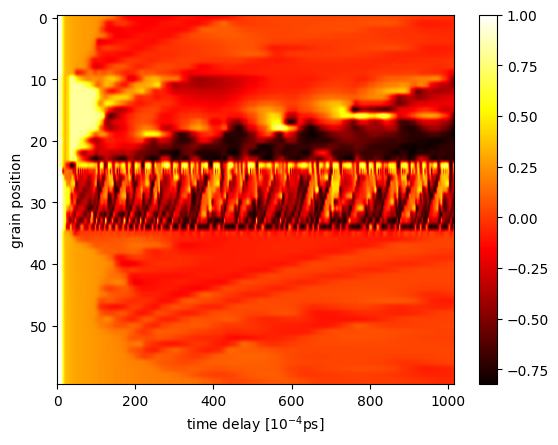

In [14]:
color_data = mm_rs[:, :, 2].T
plt.imshow(color_data, cmap='hot', aspect='auto')
plt.ylabel(r'grain position')
plt.xlabel(r'time delay [$10^{-4}$ps]')
plt.colorbar()
plt.show()

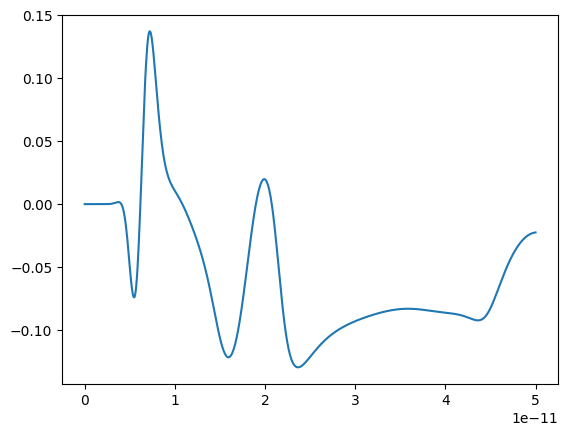

In [15]:
plt.plot(sim_delay, mm_rs[:,0,0])
plt.show()

In [16]:
print(mag_map.t)

[0.00000000e+00 3.32002917e-14 6.44273318e-14 ... 4.99146575e-11
 4.99869080e-11 4.99999500e-11]
